# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [4]:
import pandas as pd
import numpy as np

files = {
    "Panama City": "data/PanamaCityWeather.csv",
    "Gainesville": "data/GainsvilleWeather.csv",
    "Miami": "data/MiamiWeather.csv",
    "Orlando": "data/OrlandoWeather.csv",
    "Tampa": "data/TampaWeather.csv"
}
dfs = []
for city, file_path in files.items():
    df = pd.read_csv(file_path)
    df['City'] = city
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
#clean up white spaces
combined_df.columns = combined_df.columns.str.strip()
# change -99 to nan to rmeove later
combined_df.replace([-99.9, -99.99], np.nan, inplace=True)

combined_df['Date'] = pd.to_datetime(
    combined_df[['YEAR', 'MONTH', 'DAY']].rename(columns={
        'YEAR': 'year', 'MONTH': 'month', 'DAY': 'day'
    }),
    errors='coerce'
)
# remove any of the -99
combined_df.dropna(subset=['Date'], inplace=True)
#remove any of the -99
combined_df_clean = combined_df.dropna(subset=["PRECIPITATION", "MAX TEMP", "MIN TEMP", "MEAN TEMP"])

combined_df_clean.reset_index(drop=True, inplace=True)

print(combined_df_clean.head())


   COOPID  YEAR  MONTH  DAY  PRECIPITATION  MAX TEMP  MIN TEMP  MEAN TEMP  \
0   83326  1960      5   17            0.0      90.0      64.0       77.0   
1   83326  1960      5   18            0.0      92.0      62.0       77.0   
2   83326  1960      5   19            0.0      94.0      59.0       76.5   
3   83326  1960      5   20            0.0      89.0      68.0       78.5   
4   83326  1960      5   21            0.0      91.0      65.0       78.0   

          City       Date  
0  Panama City 1960-05-17  
1  Panama City 1960-05-18  
2  Panama City 1960-05-19  
3  Panama City 1960-05-20  
4  Panama City 1960-05-21  


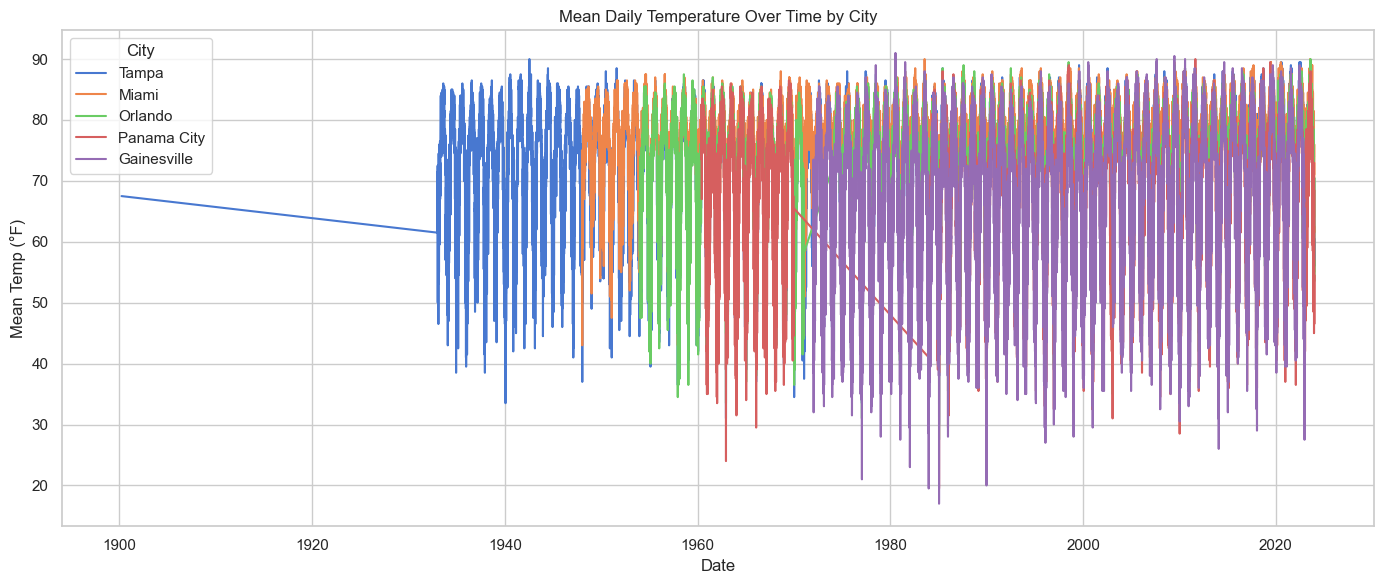

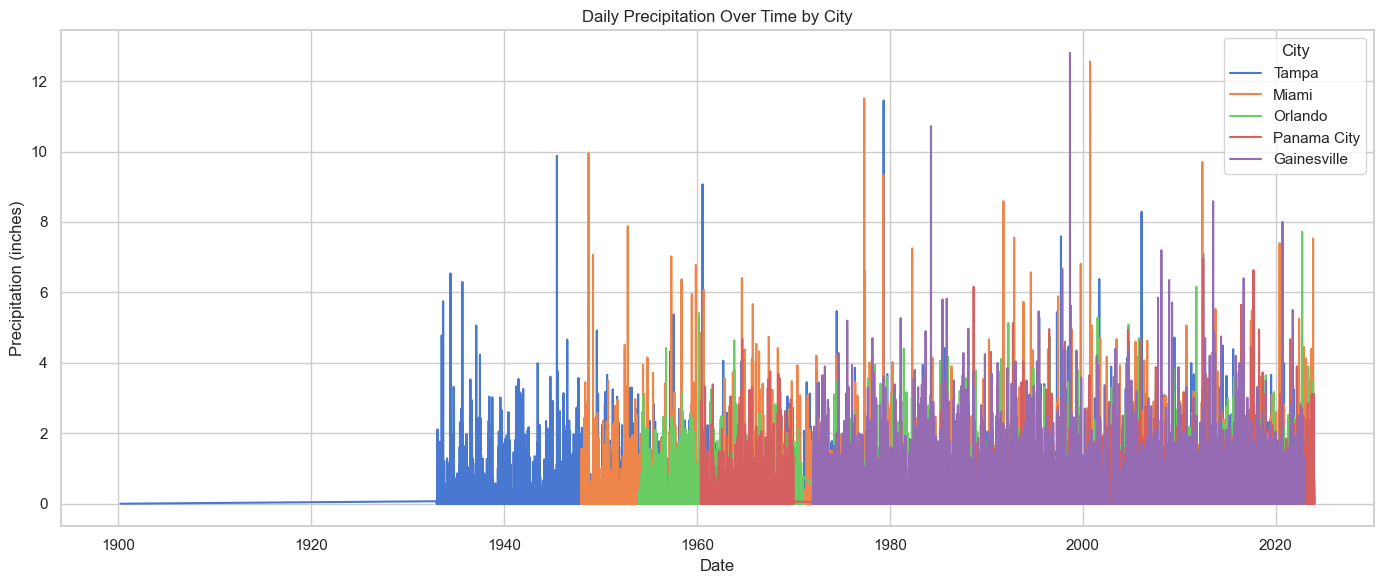

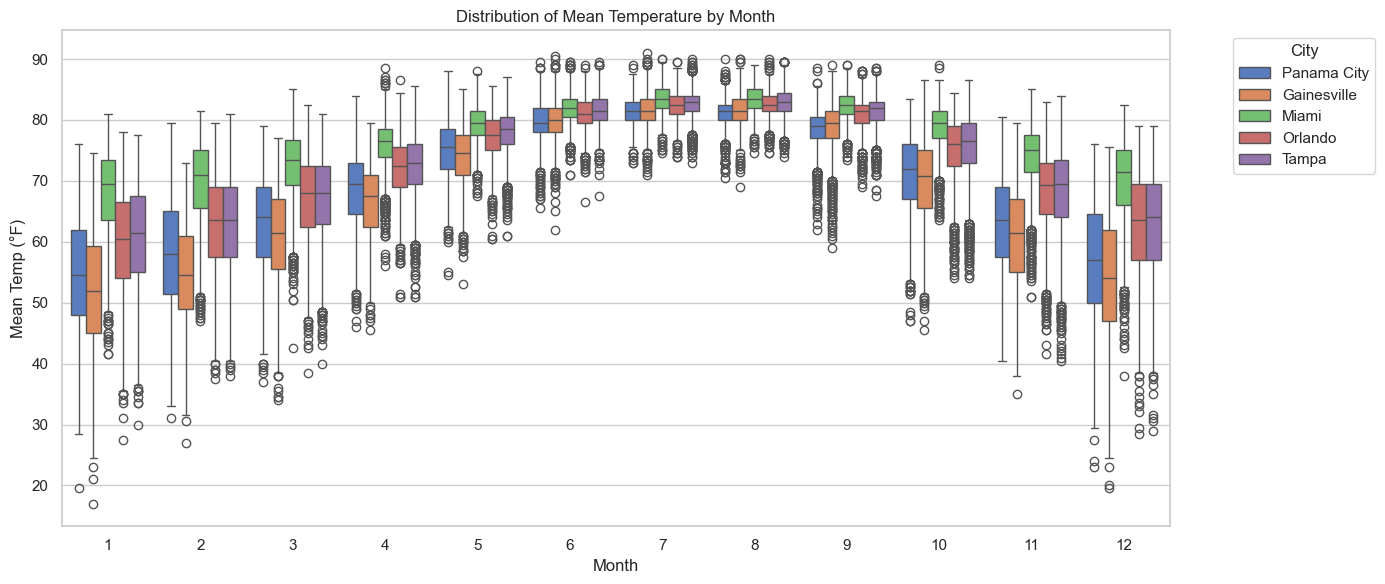

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (12, 6)

city_daily_avg = combined_df_clean.groupby(['Date', 'City']).agg({
    'PRECIPITATION': 'mean',
    'MEAN TEMP': 'mean',
    'MAX TEMP': 'mean',
    'MIN TEMP': 'mean'
}).reset_index()

#mean temp over time but again doesnt look great
plt.figure(figsize=(14, 6))
sns.lineplot(data=city_daily_avg, x='Date', y='MEAN TEMP', hue='City')
plt.title("Mean Daily Temperature Over Time by City")
plt.xlabel("Date")
plt.ylabel("Mean Temp (°F)")
plt.legend(title='City')
plt.tight_layout()
plt.show()

#precipitation over time but it doesnt look great
plt.figure(figsize=(14, 6))
sns.lineplot(data=city_daily_avg, x='Date', y='PRECIPITATION', hue='City')
plt.title("Daily Precipitation Over Time by City")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.legend(title='City')
plt.tight_layout()
plt.show()

#box plot of temp by month idk if this helps?
combined_df_clean.loc['Month'] = combined_df_clean['Date'].dt.month

plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_df_clean, x='Month', y='MEAN TEMP', hue='City')
plt.title("Distribution of Mean Temperature by Month")
plt.xlabel("Month")
plt.ylabel("Mean Temp (°F)")
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



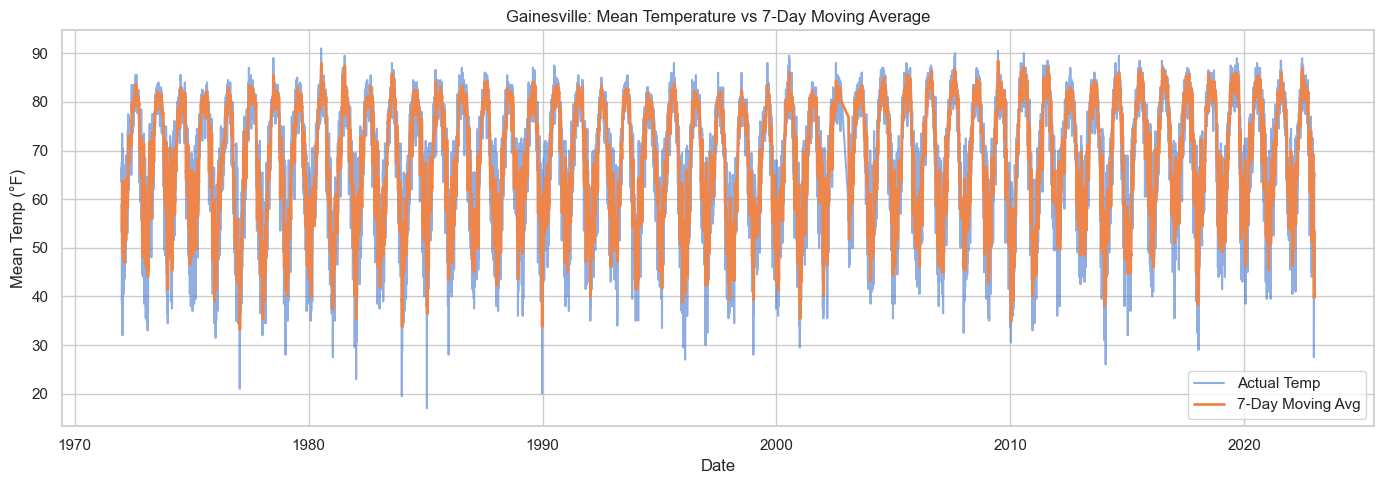

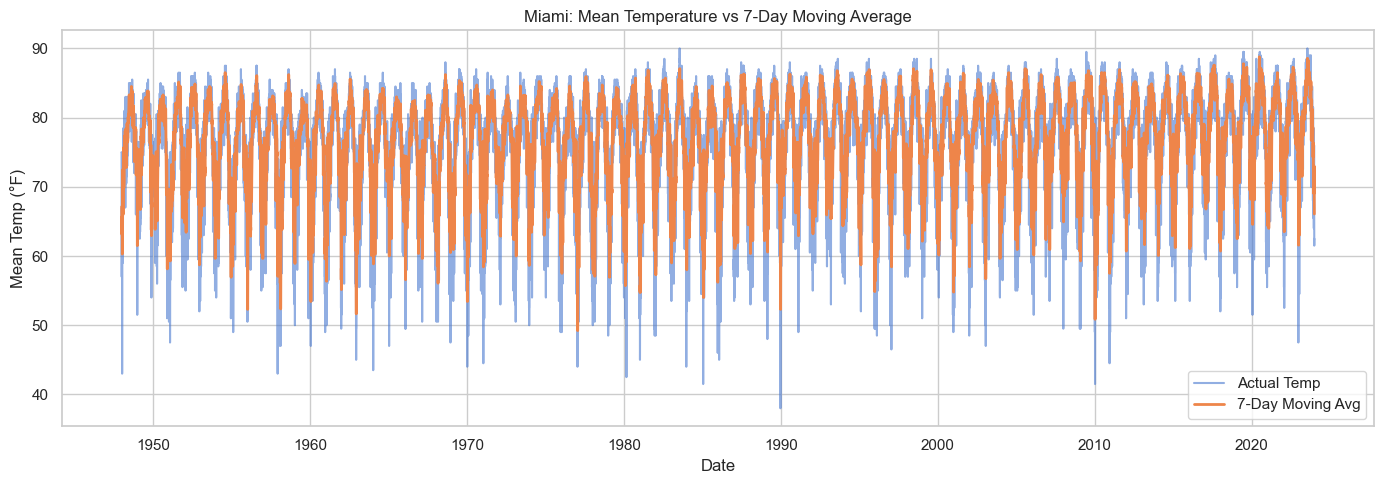

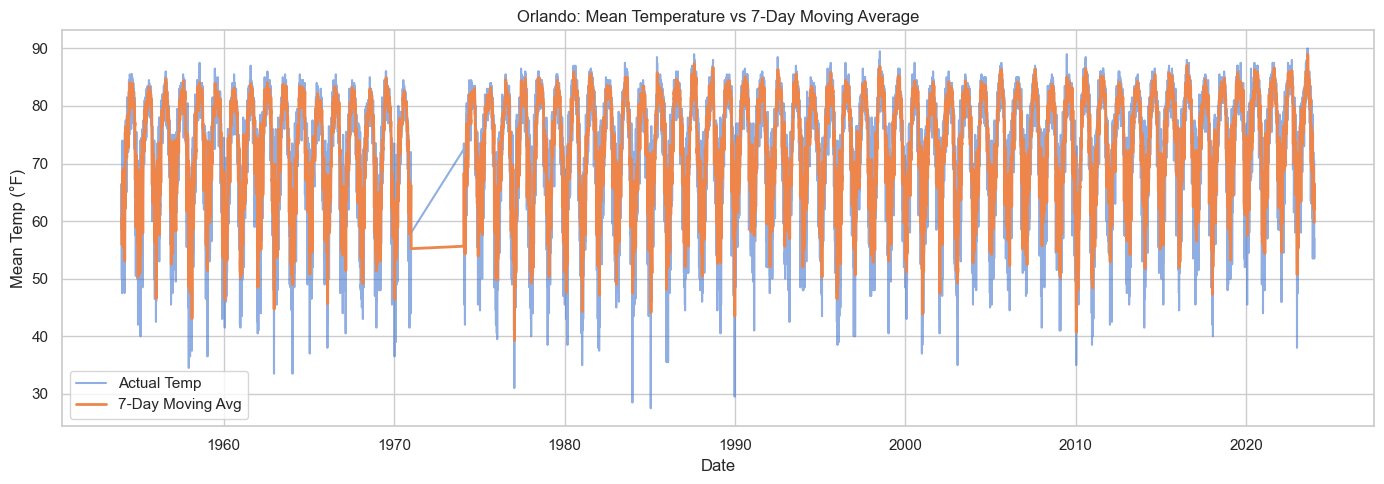

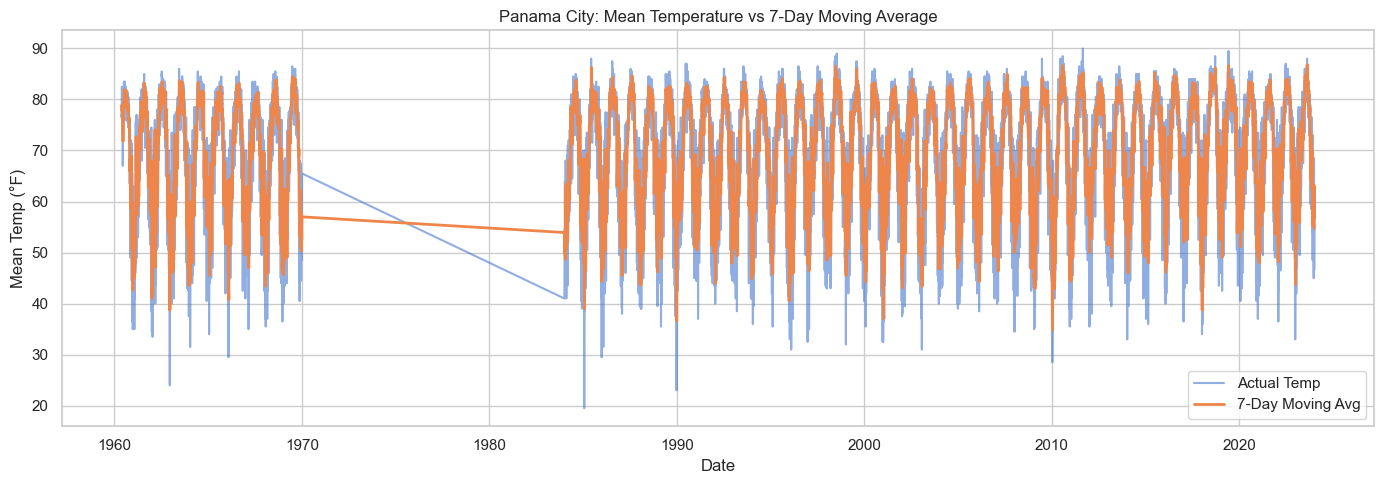

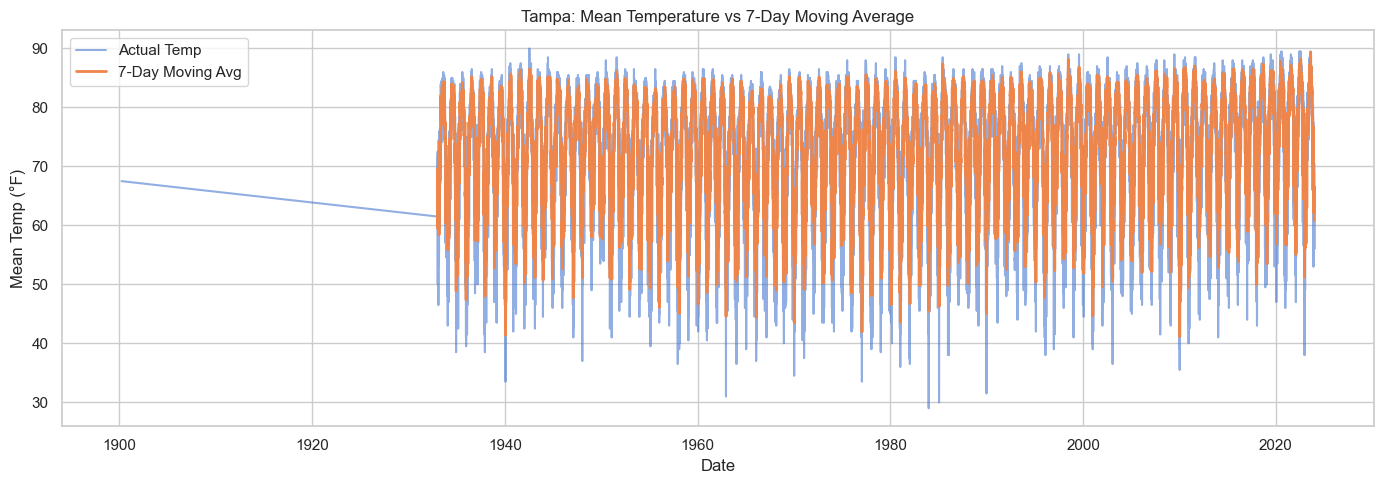

In [7]:
#7 day moving average for each of the cities
city_ma_df = combined_df_clean.copy()
city_ma_df.sort_values(by=["City", "Date"], inplace=True)

city_ma_df["TEMP_7D_MA"] = city_ma_df.groupby("City")["MEAN TEMP"].transform(lambda x: x.rolling(window=7).mean())
city_ma_df["PRECIP_7D_MA"] = city_ma_df.groupby("City")["PRECIPITATION"].transform(lambda x: x.rolling(window=7).mean())

cities = city_ma_df["City"].unique()

for city in cities:
    city_data = city_ma_df[city_ma_df["City"] == city]
    plt.figure(figsize=(14, 5))
    sns.lineplot(data=city_data, x="Date", y="MEAN TEMP", label="Actual Temp", alpha=0.6)
    sns.lineplot(data=city_data, x="Date", y="TEMP_7D_MA", label="7-Day Moving Avg", linewidth=2)
    plt.title(f"{city}: Mean Temperature vs 7-Day Moving Average")
    plt.xlabel("Date")
    plt.ylabel("Mean Temp (°F)")
    plt.legend()
    plt.tight_layout()
    plt.show()


7-Day Moving Average Forecast for Panama City (Mean Temperature):
        Date  Forecasted_MEAN_TEMP
0 2024-01-02             54.642857
1 2024-01-03             54.642857
2 2024-01-04             54.642857
3 2024-01-05             54.642857
4 2024-01-06             54.642857
5 2024-01-07             54.642857
6 2024-01-08             54.642857


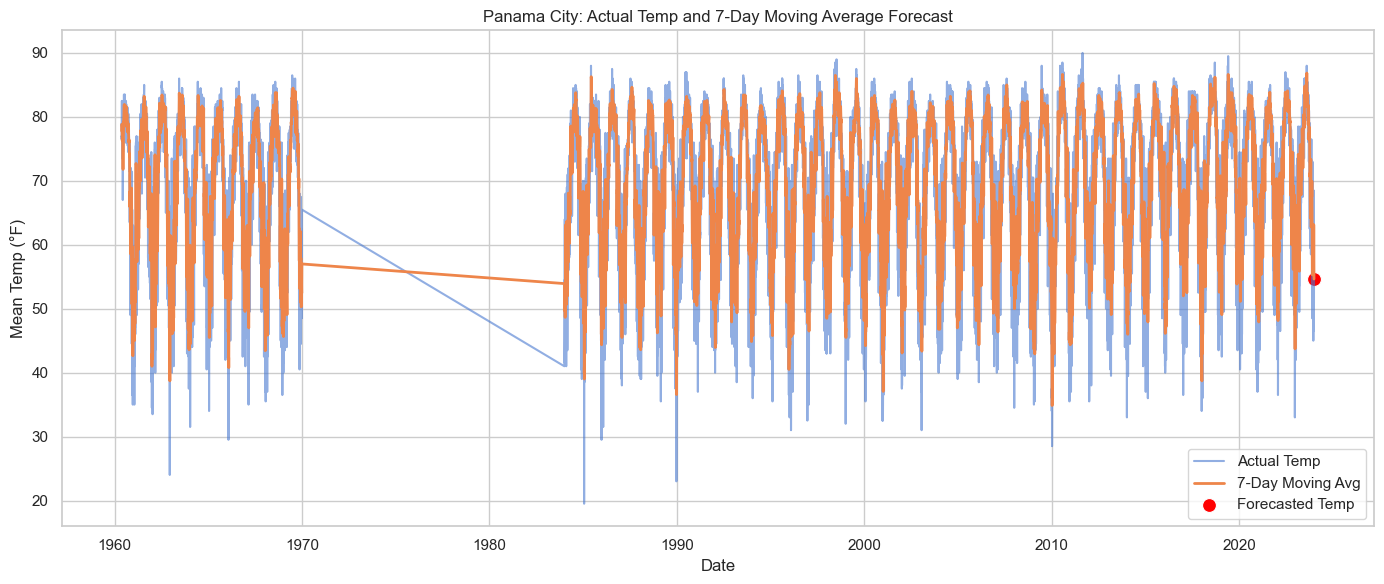

7-Day Moving Average Forecast for Gainesville (Mean Temperature):
        Date  Forecasted_MEAN_TEMP
0 2023-01-02             53.428571
1 2023-01-03             53.428571
2 2023-01-04             53.428571
3 2023-01-05             53.428571
4 2023-01-06             53.428571
5 2023-01-07             53.428571
6 2023-01-08             53.428571


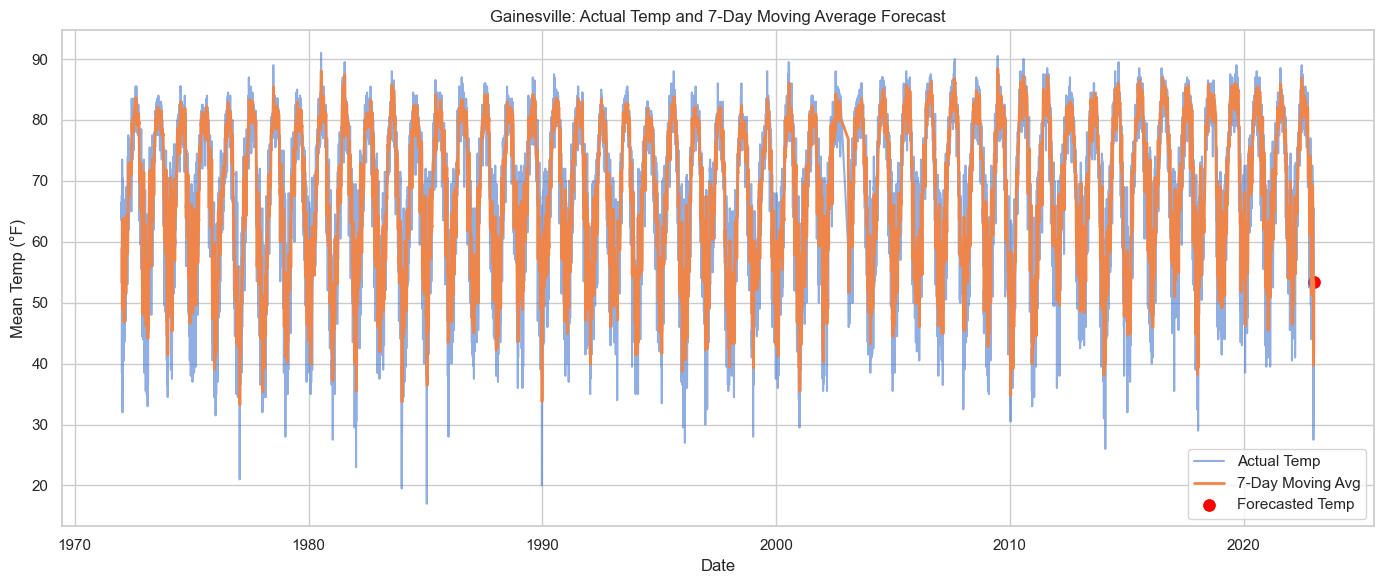

7-Day Moving Average Forecast for Miami (Mean Temperature):
        Date  Forecasted_MEAN_TEMP
0 2024-01-02             66.071429
1 2024-01-03             66.071429
2 2024-01-04             66.071429
3 2024-01-05             66.071429
4 2024-01-06             66.071429
5 2024-01-07             66.071429
6 2024-01-08             66.071429


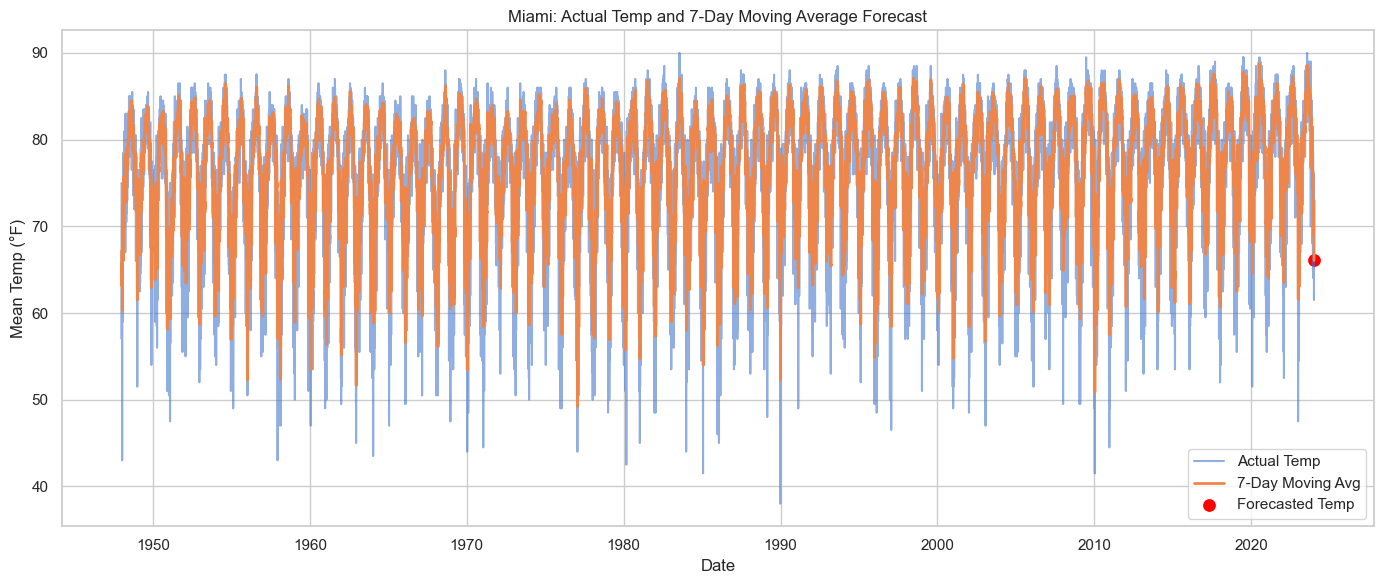

7-Day Moving Average Forecast for Orlando (Mean Temperature):
        Date  Forecasted_MEAN_TEMP
0 2024-01-02             59.785714
1 2024-01-03             59.785714
2 2024-01-04             59.785714
3 2024-01-05             59.785714
4 2024-01-06             59.785714
5 2024-01-07             59.785714
6 2024-01-08             59.785714


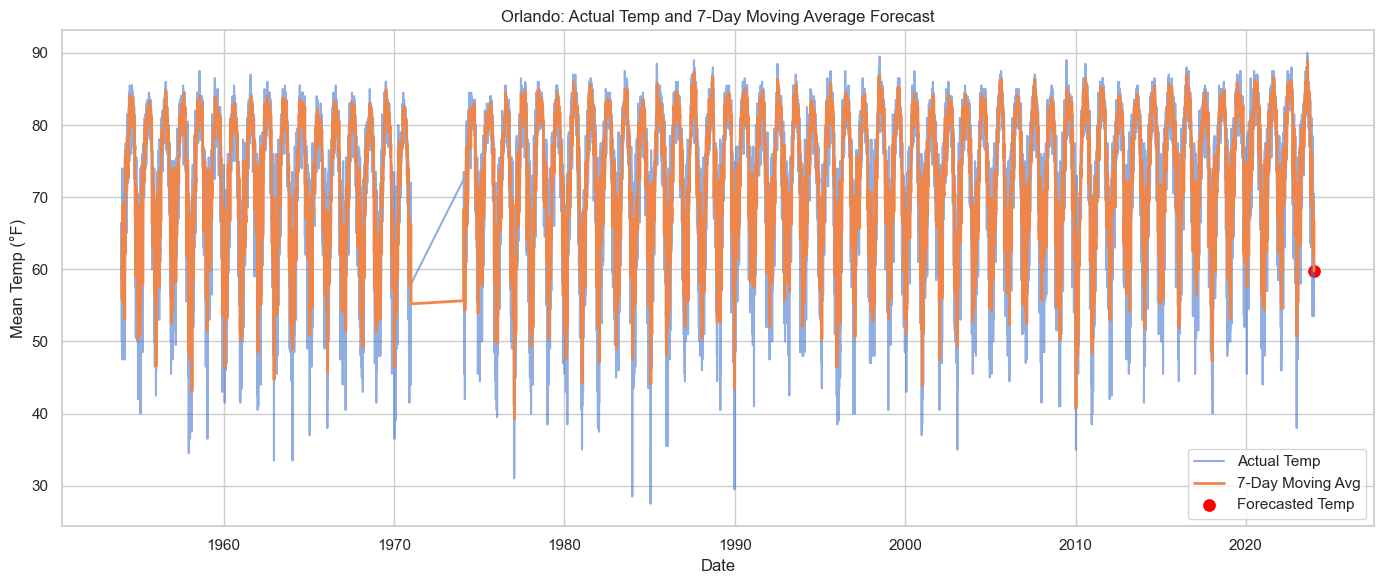

7-Day Moving Average Forecast for Tampa (Mean Temperature):
        Date  Forecasted_MEAN_TEMP
0 2024-01-02             60.785714
1 2024-01-03             60.785714
2 2024-01-04             60.785714
3 2024-01-05             60.785714
4 2024-01-06             60.785714
5 2024-01-07             60.785714
6 2024-01-08             60.785714


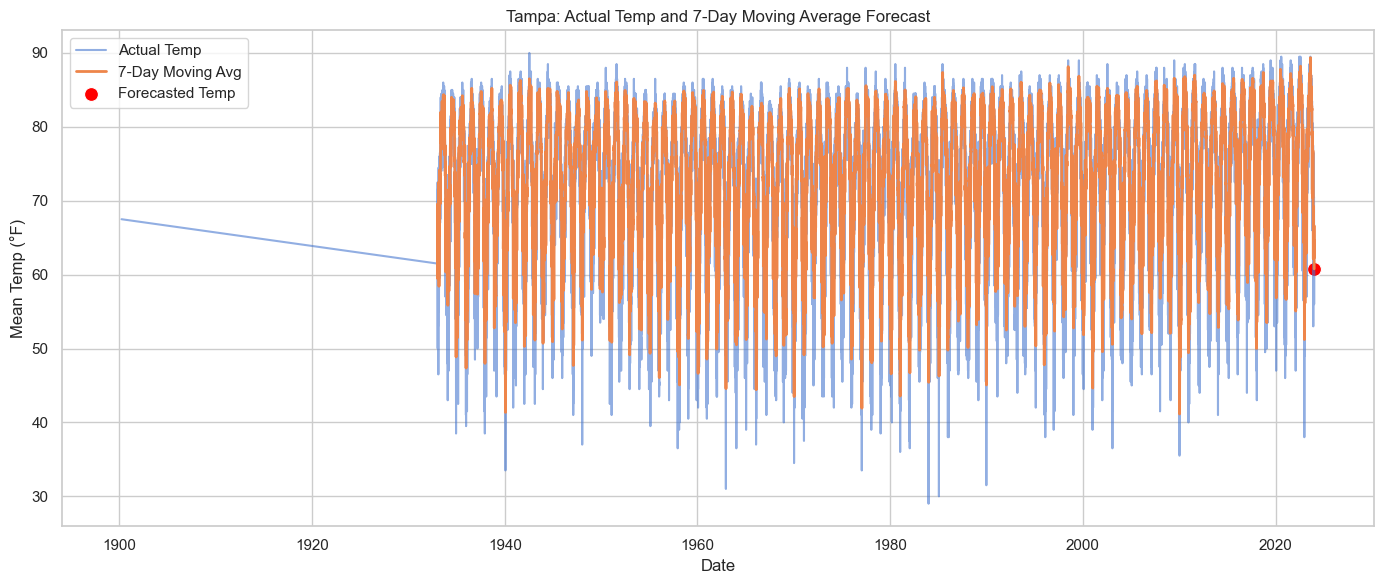

In [11]:
cities = combined_df_clean['City'].unique()

def forecast_with_moving_average(city_data, forecast_days=7):
    city_data = city_data.sort_values("Date")
    last_ma = city_data['TEMP_7D_MA'].iloc[-1]
    last_date = city_data['Date'].iloc[-1]
    #set up the forecast dates for predictions
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days)
    forecast = pd.DataFrame({
        'Date': forecast_dates,
        'Forecasted_MEAN_TEMP': [last_ma] * forecast_days
    })
    return forecast

for city in cities:
    # moving average for each city
    city_data = city_ma_df[city_ma_df["City"] == city].copy().sort_values("Date")
    forecast = forecast_with_moving_average(city_data, forecast_days=7)

    print(f"7-Day Moving Average Forecast for {city} (Mean Temperature):")
    print(forecast)

    plt.figure(figsize=(14, 6))
    sns.lineplot(data=city_data, x="Date", y="MEAN TEMP", label="Actual Temp", alpha=0.6)
    sns.lineplot(data=city_data, x="Date", y="TEMP_7D_MA", label="7-Day Moving Avg", linewidth=2)
    sns.scatterplot(data=forecast, x="Date", y="Forecasted_MEAN_TEMP", color="red", label="Forecasted Temp", s=100)
    plt.title(f"{city}: Actual Temp and 7-Day Moving Average Forecast")
    plt.xlabel("Date")
    plt.ylabel("Mean Temp (°F)")
    plt.legend()
    plt.tight_layout()
    plt.show()

Linear Regression Model for Panama City:
  Coefficients: [0.02124473 0.01983153]
  Intercept: 25.577412926634523
  R-squared on test set: 0.02493297739136835


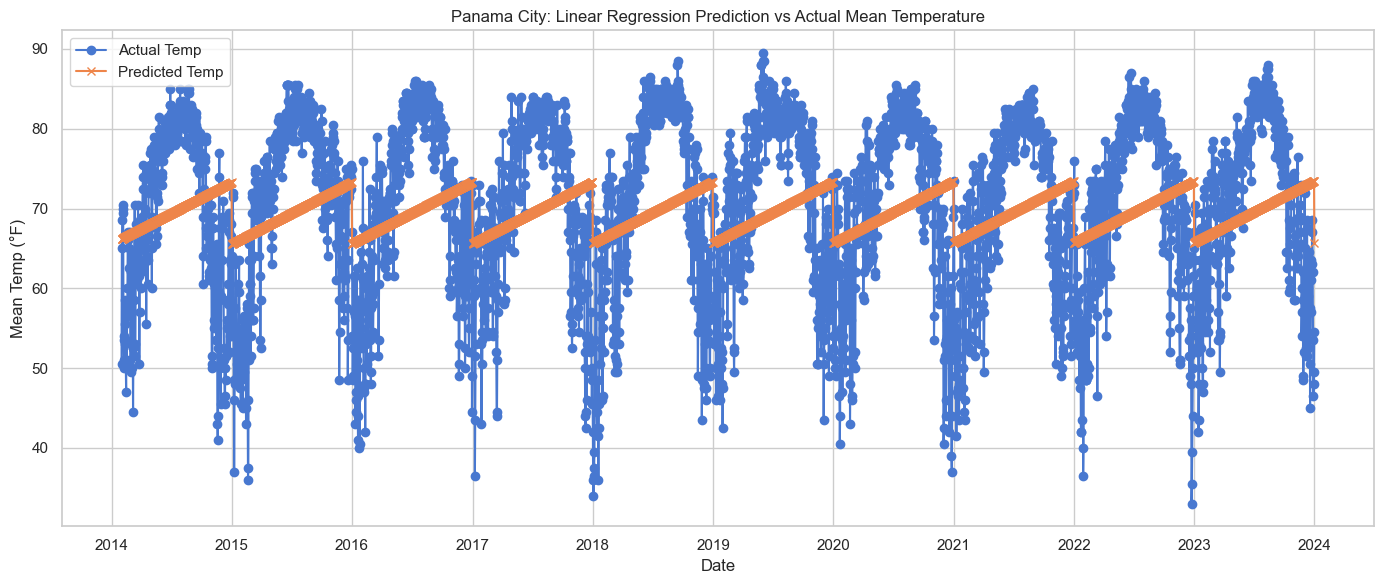

Linear Regression Model for Gainesville:
  Coefficients: [0.02717947 0.07382798]
  Intercept: -84.28404118858671
  R-squared on test set: 0.05342763834953723


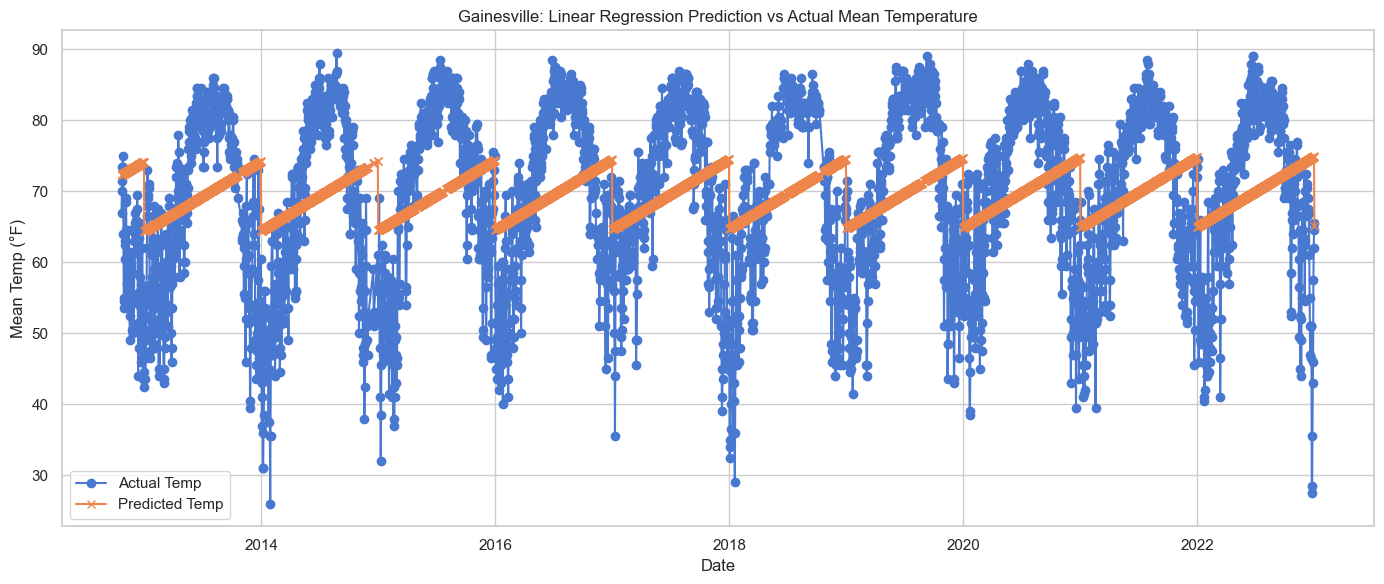

Linear Regression Model for Miami:
  Coefficients: [0.0174026  0.03928212]
  Intercept: -4.5863697132513295
  R-squared on test set: 0.06505126382378579


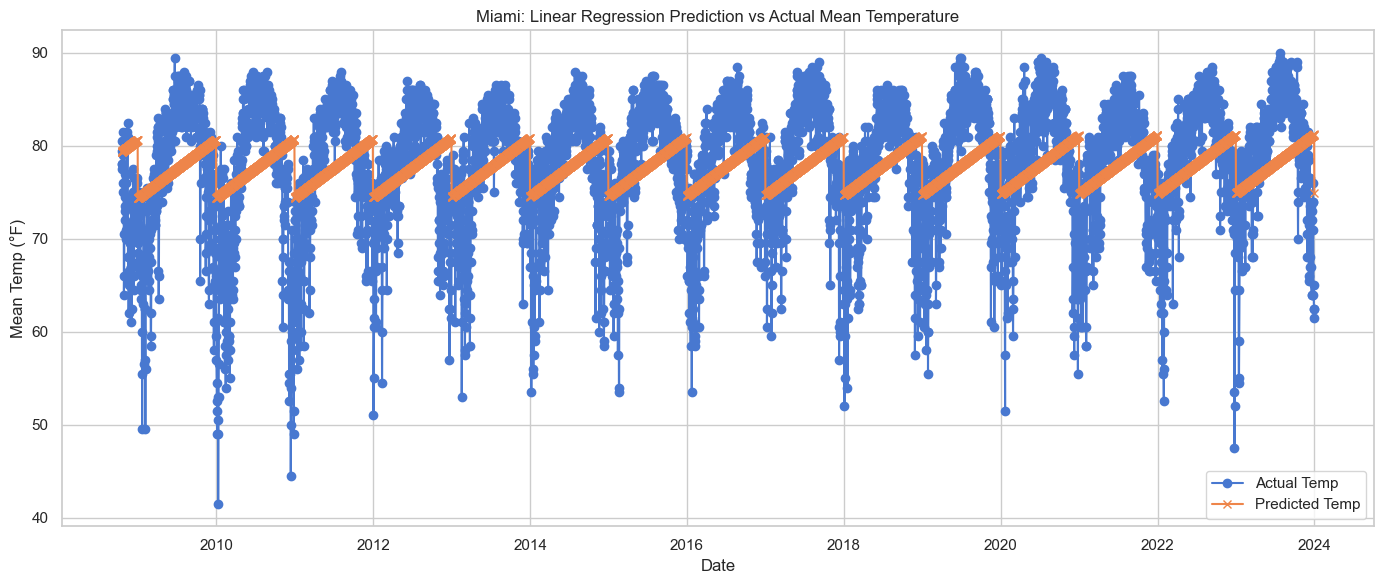

Linear Regression Model for Orlando:
  Coefficients: [0.02268514 0.03224884]
  Intercept: 4.269952696550092
  R-squared on test set: 0.030594887878618304


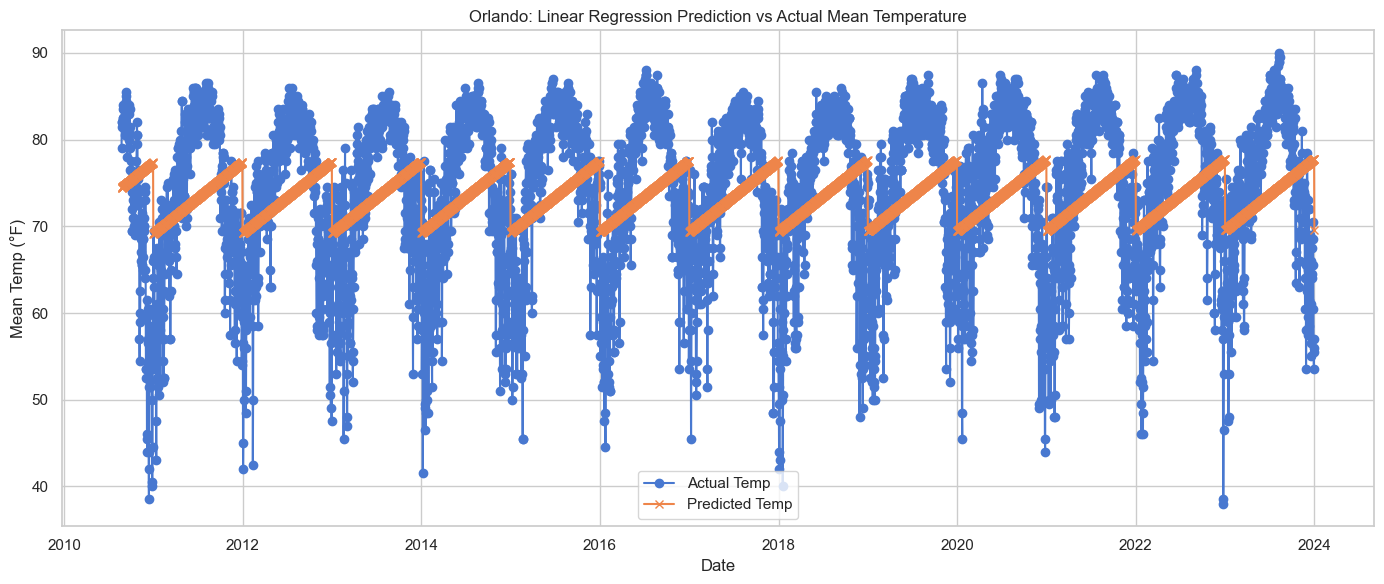

Linear Regression Model for Tampa:
  Coefficients: [0.0209118  0.01136597]
  Intercept: 46.46891297867766
  R-squared on test set: 0.02583310269253969


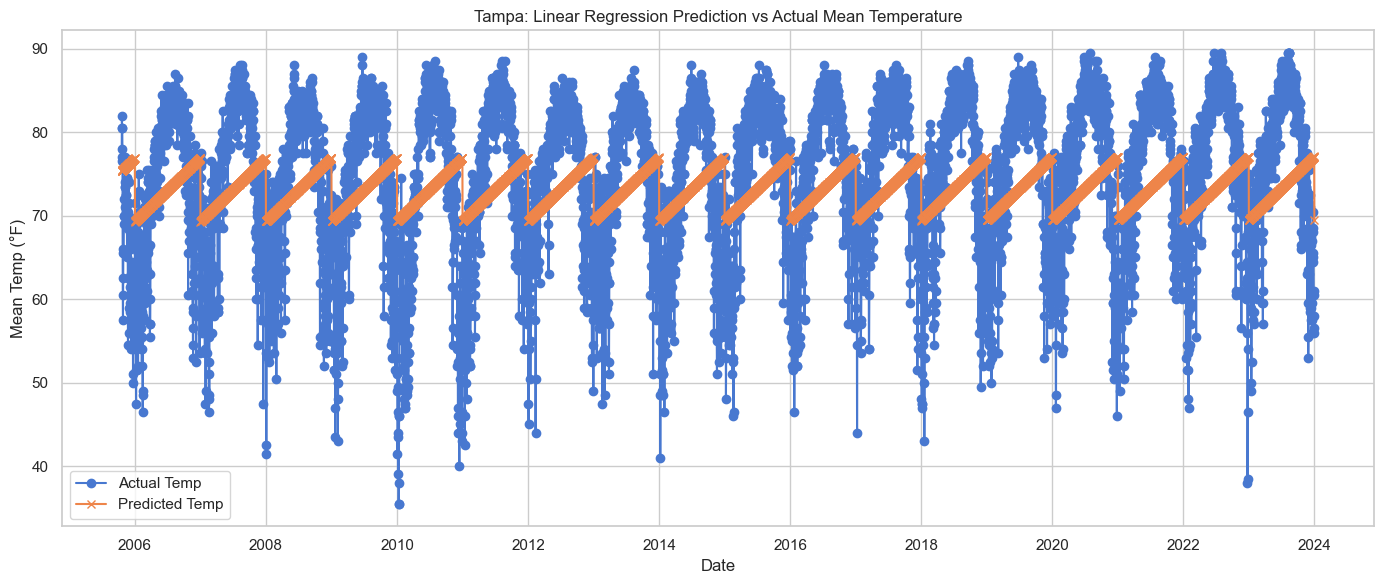

In [13]:
from sklearn.linear_model import LinearRegression

for city in cities:
    # sort the data and filter it
    city_lr = combined_df_clean[combined_df_clean['City'] == city].copy().sort_values("Date")
    #when using regression i need it to be date based
    city_lr['day_of_year'] = city_lr['Date'].dt.dayofyear
    city_lr['year'] = city_lr['Date'].dt.year
    X = city_lr[['day_of_year', 'year']]
    y = city_lr['MEAN TEMP']
    # split the data between training and testing (might mess around with this more)
    split_index = int(len(city_lr) * 0.8)
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    #training stuff
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    # evaluation with r squared
    r2 = lr_model.score(X_test, y_test)
    print(f"Linear Regression Model for {city}:")
    print("  Coefficients:", lr_model.coef_)
    print("  Intercept:", lr_model.intercept_)
    print("  R-squared on test set:", r2)
    #difference between what the actual is vs the predicted temp
    plt.figure(figsize=(14, 6))
    plt.plot(city_lr['Date'].iloc[split_index:], y_test, marker='o', label="Actual Temp")
    plt.plot(city_lr['Date'].iloc[split_index:], lr_model.predict(X_test), marker='x', label="Predicted Temp")
    plt.title(f"{city}: Linear Regression Prediction vs Actual Mean Temperature")
    plt.xlabel("Date")
    plt.ylabel("Mean Temp (°F)")
    plt.legend()
    plt.tight_layout()
    plt.show()